In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')


In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="newApp", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
#sc = spark.sparkContext

In [6]:
from pyspark.sql.functions import isnan, count, col

In [7]:
df1 = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("PapJournalCSCI.csv")

In [8]:
df1.printSchema()

root
 |-- ConfInstanceID: long (nullable = true)
 |-- ConfSeriesID: long (nullable = true)
 |-- JournalID: long (nullable = true)
 |-- PaperID: long (nullable = true)
 |-- Paper_Rank: integer (nullable = true)
 |-- Paper_RefCnt: integer (nullable = true)
 |-- CitationCount: integer (nullable = true)
 |-- EstimatedCount: integer (nullable = true)
 |-- Journal_Rank: integer (nullable = true)
 |-- Journal_Pap_Cnt: integer (nullable = true)
 |-- Journal_Cit_Cnt: integer (nullable = true)
 |-- CSRank: integer (nullable = true)
 |-- CSPaperCount: integer (nullable = true)
 |-- CSCitation: integer (nullable = true)
 |-- CIRank: integer (nullable = true)
 |-- CIPaperCount: integer (nullable = true)
 |-- CIPaperCitationCnt: integer (nullable = true)
 |-- DocTypeIndex: double (nullable = true)



In [9]:
drop_cols = ['ConfInstanceID','ConfSeriesID','JournalID']
df1 = df1.drop(*drop_cols)

In [10]:
df1.count()

90728

In [11]:
df1 = df1.withColumnRenamed("CitationCount","label")

In [12]:
df1.show(1)

+----------+----------+------------+-----+--------------+------------+---------------+---------------+------+------------+----------+------+------------+------------------+------------+
|   PaperID|Paper_Rank|Paper_RefCnt|label|EstimatedCount|Journal_Rank|Journal_Pap_Cnt|Journal_Cit_Cnt|CSRank|CSPaperCount|CSCitation|CIRank|CIPaperCount|CIPaperCitationCnt|DocTypeIndex|
+----------+----------+------------+-----+--------------+------------+---------------+---------------+------+------------+----------+------+------------+------------------+------------+
|1819143627|     24199|           0|    0|             0|        9728|           9284|          64351| 11187|        4309|      6256| 25000|         405|               759|         0.0|
+----------+----------+------------+-----+--------------+------------+---------------+---------------+------+------------+----------+------+------------+------------------+------------+
only showing top 1 row



In [14]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
feature_list = []
for col in df1.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
# Concatenates all feature columns into a single feature vector in a new column "rawFeatures"
vectorAssembler = VectorAssembler(inputCols=feature_list, outputCol="features")
# Identifies categorical features and indexes them
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

In [15]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [16]:
from pyspark.ml.regression import RandomForestRegressor

#rf = RandomForestRegressor(labelCol="CitationCount", featuresCol="featuresCols")
rf = RandomForestRegressor(featuresCol="features")

In [17]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, rf])

In [18]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [19]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [20]:
(train, test) = df1.randomSplit([0.8, 0.2])

In [21]:
cvModel = crossval.fit(train)

In [22]:

predictions = cvModel.transform(test)

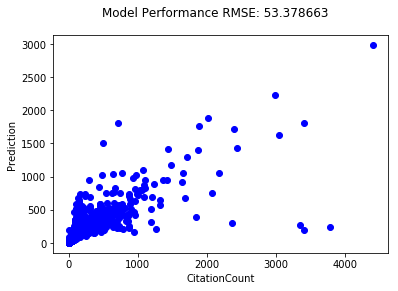

In [24]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(df1)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('CitationCount')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5,1,'Feature Importances')

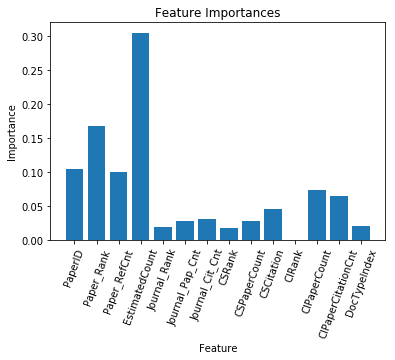

In [25]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=70)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [26]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

('numTrees - ', 30)
('maxDepth - ', 15)
